In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
from PortfolioConstruction.factor import construct_factor
from PortfolioConstruction.performance import calc_performance, calc_cum_returns, plot_corr, plot_perf

In [4]:
country_data_path = '../Data/country_data'
macro_data_path = '../Data/macro_factors'
style_data_path = '../Data/style_factors'
cluster_path = '../Outputs/country_clusters'
output_path = '../Outputs/bond'

In [5]:
start_date = '2003-10-01'

## Load Data

### Read country sovereign bond index data

In [6]:
ticker_all = pd.read_csv(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_summary.csv'), skipinitialspace=True)

# optional: can apply filter to exclude some countries; this dictionary will be used to loop for regression
# ticker = ticker_all.loc[(ticker_all['Number of Issues'] > 5) & (ticker_all['Sum of Market Value (mm, USD)'] > 10000), :].copy()
ticker = ticker_all.copy()

ticker['Country'] = ticker['Full Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))
ticker['Index Full Name'] = ticker['Index BBG Ticker'] + ' Index'
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

In [7]:
bnd_idx_price = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)

bnd_idx_price.drop(index=[0, 1], inplace=True)
bnd_idx_price.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
bnd_idx_price.set_index('Date', inplace=True)
bnd_idx_price = bnd_idx_price.astype('float')
bnd_idx_price_monthly = bnd_idx_price.resample('M').last()
bnd_idx_price_monthly.replace(0, np.nan, inplace=True)

### Read Macro Factors Data

In [8]:
credit = pd.read_csv(os.path.join(macro_data_path, 'LF98TRUU_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['credit'])
currency = pd.read_csv(os.path.join(macro_data_path, 'MXEF0CX0_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['currency'])
equity = pd.read_csv(os.path.join(macro_data_path, 'WHANWIHD_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['equity'])
rates = pd.read_csv(os.path.join(macro_data_path, 'JPM_GBIEM.csv'), skiprows=7, header=None, index_col=0, names=['rates_last', 'rates_mid'])
rates.index = pd.to_datetime(rates.index)
rates = rates.sort_index()
rates = rates[['rates_last']]
rates.columns = ['rates']

In [9]:
macro_factors = credit.join(currency, how='inner').join(equity, how='inner').join(rates, how='inner')
macro_factors_monthly = macro_factors.resample('M').last()
macro_factors_monthly = macro_factors_monthly.astype('float')

### Read 3-Months LIBOR data

In [10]:
libor = pd.read_csv('../Data/others/USD3MTD156N.csv', index_col=0)
libor.columns = ['3M_libor']
libor['3M_libor'] = libor['3M_libor'].replace(['.'], np.nan)
libor.fillna(method='ffill')
libor = libor.apply(pd.to_numeric)
libor.index = pd.to_datetime(libor.index)

libor_monthly = libor.resample('M').first() / 1200 # convert annual data in % to a monthly return
libor_monthly = libor_monthly.shift(1).dropna() # using first data of the month and shift by a period, to match bond index return's date convention - end of month date represents return earned over that month

## Regression

In [11]:
bnd_index_ret = np.log(bnd_idx_price_monthly).diff()
bnd_index_ret.replace(0, np.nan, inplace=True)
bnd_index_excess_ret = bnd_index_ret.subtract(libor_monthly['3M_libor'], axis=0).dropna(axis=0, how='all')

In [12]:
macro_factors_ret = np.log(macro_factors_monthly).diff().dropna()
macro_factors_ret.describe()

,credit,currency,equity,rates
count,191.000000,191.000000,191.000000,191.000000
mean,0.005827,0.002256,0.006560,0.003693
std,0.027960,0.019484,0.040996,0.012621
min,-0.173244,-0.078636,-0.171625,-0.039949
25%,-0.003483,-0.006882,-0.012876,-0.003229
50%,0.007352,0.003989,0.013603,0.005135
75%,0.016999,0.013584,0.030295,0.010941
max,0.114263,0.050544,0.114004,0.066541


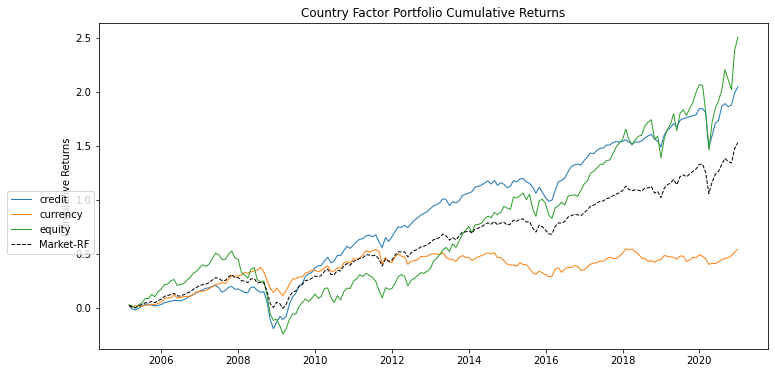

In [15]:
macro_factors_cum_ret = calc_cum_returns(macro_factors_ret)

# Plot cumulative returns
plot_perf(perf=[macro_factors_cum_ret[x] for x in list(macro_factors_cum_ret.columns.values)[:-1]],
          perf_bm=macro_factors_cum_ret.mean(axis=1), # to be replaced by true bench later 
          label=macro_factors_ret.columns, 
          title='Country Factor Portfolio Cumulative Returns')

### Run regression

In [16]:
results_df = pd.DataFrame()
results_dict = {} 

cols = ['const'] + macro_factors_ret.columns.tolist()
beta_cols = [x + '_beta' for x in cols]
tval_cols = [x + '_tval' for x in cols]

for bnd_index in bnd_index_excess_ret:
    
    country = ticker_dict[bnd_index]
    temp = bnd_index_excess_ret[bnd_index].dropna().to_frame().join(macro_factors_ret, how='inner')
    
    if temp.shape[0] > 30:

        y = temp.iloc[:, 0]
        X = temp.iloc[:, 1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()

        betas = results.params
        tvalues = results.tvalues
        rsq_adj = results.rsquared_adj
        f_pvalue = results.f_pvalue
        begin_date = min(y.index.min(), X.index.min()).strftime('%Y%m')
        temp_results_df = pd.DataFrame(data=np.r_[betas, tvalues, rsq_adj, f_pvalue], 
                                       index=beta_cols + tval_cols + ['rsq_adj', 'f_pvalue']).T
        temp_results_df['country'] = country
        temp_results_df['begin_date'] = begin_date
        results_df = results_df.append(temp_results_df)
    
        results_dict[country] = results


In [17]:
results_df.describe()

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,6.400000e+01
mean,-0.002390,0.751348,0.106040,-0.070305,0.559986,-0.372298,4.670096,0.019016,-0.773608,3.980593,0.423721,1.465004e-02
std,0.008071,0.806349,0.567295,0.190735,0.553070,1.295290,2.764371,1.439763,1.137473,3.444024,0.192534,7.975603e-02
min,-0.057076,-0.273499,-0.418816,-1.346559,-1.598084,-2.738879,-1.004248,-3.662358,-3.699185,-0.839482,-0.028561,1.721245e-47
25%,-0.003041,0.273274,-0.130448,-0.099070,0.254424,-1.192815,2.151888,-1.043907,-1.500113,0.927711,0.269731,1.885005e-28
50%,-0.000790,0.543780,-0.024736,-0.055490,0.565073,-0.447948,5.333330,-0.207836,-0.701890,3.455733,0.471820,5.495120e-18
75%,0.000399,0.954905,0.181010,-0.006013,0.912735,0.259847,6.558800,0.914314,-0.091505,6.292737,0.569895,5.809884e-10
max,0.010109,4.676858,3.977731,0.184428,1.800138,3.250745,10.186300,3.753299,1.903005,11.790931,0.693218,6.138402e-01


## Regression Results by Cluster

In [18]:
bond_idx_clusters = pd.read_pickle(os.path.join(cluster_path, 'clusters_bond_idx_ret_full.pkl'))
bond_idx_clusters.head()

,Countries,cluster_label
0,Bulgaria,0
1,Bolivia,0
2,Ukraine,0
3,Venezuela,0
4,El Salvador,1


In [19]:
results_with_cluster = results_df.merge(bond_idx_clusters, left_on='country', right_on='Countries')

In [20]:
beta_reformatted = results_with_cluster.set_index('cluster_label')[beta_cols].stack().to_frame().reset_index()
beta_reformatted.columns = ['cluster', 'beta', 'value']

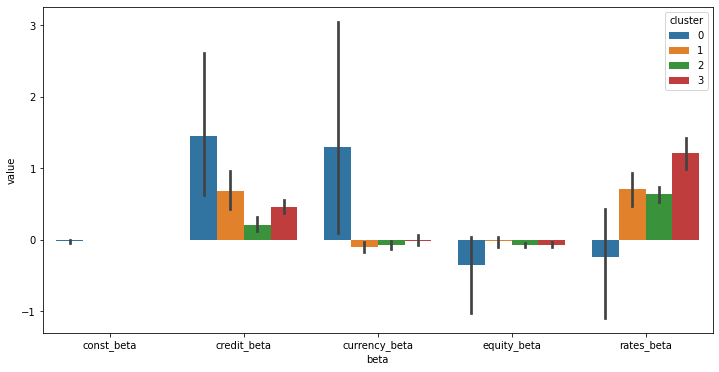

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='beta', y='value', data=beta_reformatted, hue='cluster')

In [22]:
tval_reformatted = results_with_cluster.set_index('cluster_label')[tval_cols].stack().to_frame().reset_index()
tval_reformatted.columns = ['cluster', 'tval', 'value']

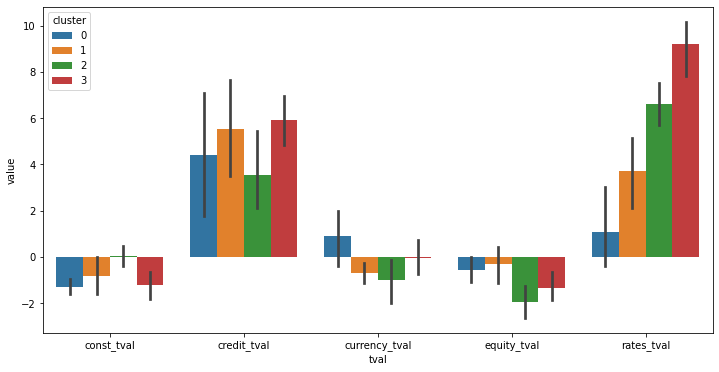

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='tval', y='value', data=tval_reformatted, hue='cluster')

In [24]:
beta_df = results_with_cluster.set_index('country')[beta_cols].T

In [25]:
tval_df = results_with_cluster.set_index('country')[tval_cols].T

In [26]:
def plot_cluster_betas(clusters_df, betas_df, cluster_n, ylim, ytitle):
    # Plot betas for each cluster
    cluster_list = list(clusters_df[clusters_df['cluster_label']==cluster_n]['Countries'])
    betas_df_tmp = betas_df[cluster_list]
    
    #no_const = betas_df_tmp.T[betas_df_tmp.T.columns[~betas_df_tmp.T.columns.isin(['const'])]]
    betas_df_tmp.T.plot(kind='bar', rot=0, figsize=(16,3))
    plt.legend(loc='upper left')
    plt.ylabel(ytitle)
    plt.ylim(-ylim,ylim)

def plot_multiple_clusters(clusters_df, betas_df, ylim, ytitle):
    all_cluster_labels = list(clusters_df['cluster_label'].unique())
    #fig, ax = plt.subplots(nrows=len(all_cluster_labels), constrained_layout=True, figsize=(12,8))
    for label_ in all_cluster_labels:
        plot_cluster_betas(clusters_df, betas_df, label_, ylim, ytitle)

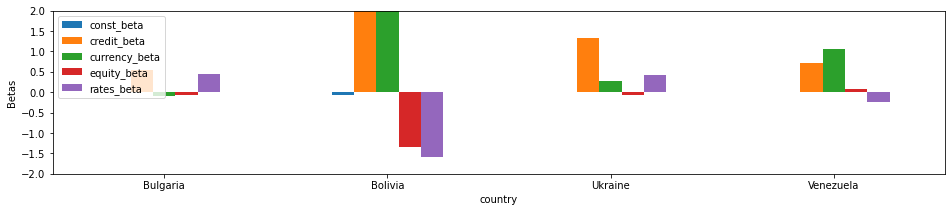

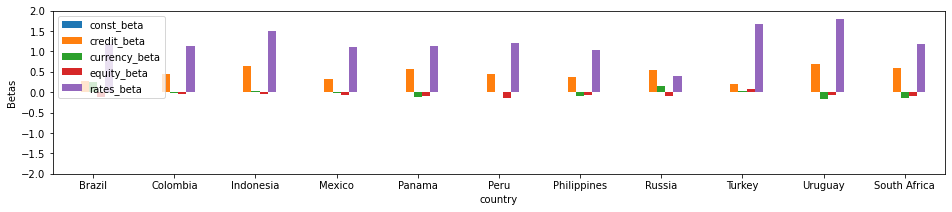

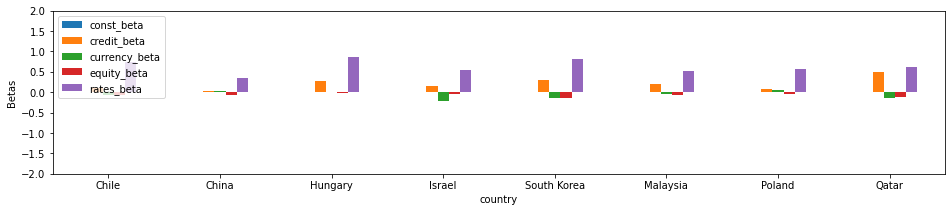

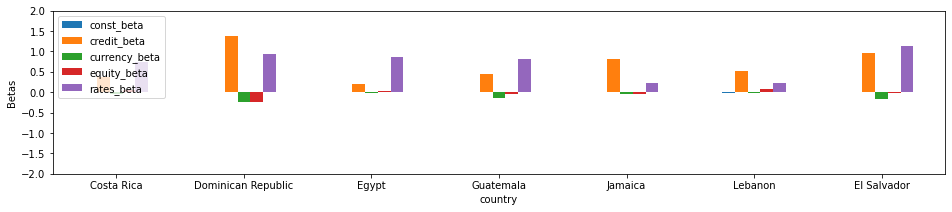

In [27]:
plot_multiple_clusters(results_with_cluster, beta_df, 2, 'Betas')

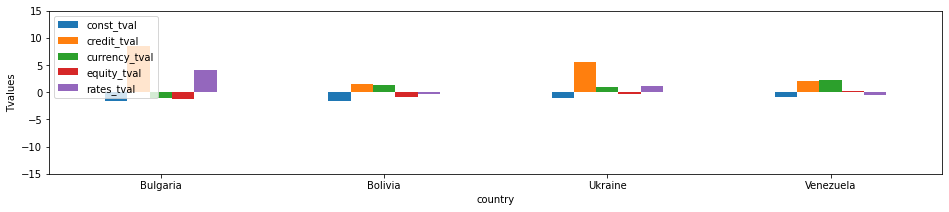

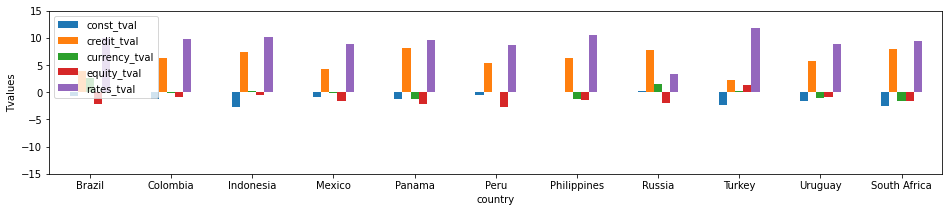

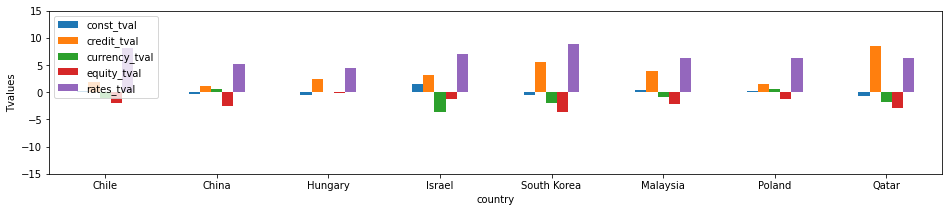

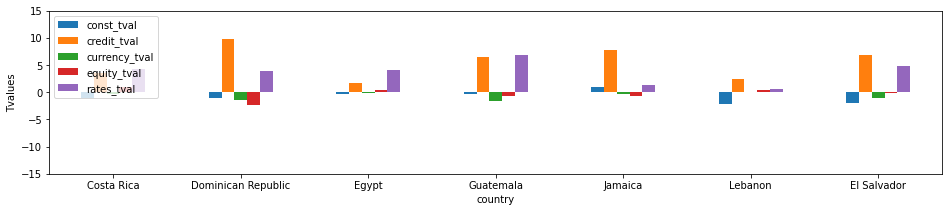

In [28]:
plot_multiple_clusters(results_with_cluster, tval_df, 15, 'Tvalues')

## Construct Style Factors

### Load index characteristics data

In [29]:
# read oas over gov data for all sov bond indices
oas1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats1.csv'), header=1, parse_dates=[0], nrows=7574, skipinitialspace=True)
oas1.dropna(axis=1, how="all", inplace=True) # delete empty column

oas2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats2.csv'), header=1, parse_dates=[0], nrows=7552, skipinitialspace=True)
oas2.dropna(axis=1, how="all", inplace=True)

oas3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats3.csv'), header=1, parse_dates=[0], nrows=6764, skipinitialspace=True)
oas3.dropna(axis=1, how="all", inplace=True)

oas4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats4.csv'), header=1, parse_dates=[0], nrows=6912, skipinitialspace=True)
oas4.dropna(axis=1, how="all", inplace=True)

oas = oas1[oas1['Date'] > start_date].merge(oas2, on='Date').merge(oas3, on='Date').merge(oas4, on='Date')
oas_monthly = oas.set_index('Date').resample('M').last()
oas_monthly.columns = oas_monthly.columns + ' Index'

In [30]:
# read foreign currency long term bond Moody's rating data
rating = pd.read_csv(os.path.join(style_data_path, 'sov_bond_rating.csv'), parse_dates=[1], usecols=[0, 2, 3])
rating.rename(columns={'rating_numerical':'rating'}, inplace=True)

In [31]:
rating_unstacked = rating.set_index(['action_date', 'country']).unstack()['rating']
rating_daily = rating_unstacked.resample('D').ffill()
rating_daily = rating_daily.fillna(method='ffill')
rating_monthly = rating_daily[rating_daily.index > start_date].resample('M').last()
rating_monthly = rating_monthly.iloc[:-1, :] # drop 2020-Feb data to align with index data 

In [32]:
# # read sovereign bond index full market value data
# mv1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value1.csv'), header=1, parse_dates=[0], nrows=350, skipinitialspace=True)
# mv1.dropna(axis=1, how="all", inplace=True) # delete empty column

# mv2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value2.csv'), header=1, parse_dates=[0], nrows=349, skipinitialspace=True)
# mv2.dropna(axis=1, how="all", inplace=True)

# mv3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value3.csv'), header=1, parse_dates=[0], nrows=316, skipinitialspace=True)
# mv3.dropna(axis=1, how="all", inplace=True)

# mv4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value4.csv'), header=1, parse_dates=[0], nrows=350, skipinitialspace=True)
# mv4.dropna(axis=1, how="all", inplace=True)

# mv = mv1[mv1['Date'] > start_date].merge(mv2, on='Date').merge(mv3, on='Date').merge(mv4, on='Date')
# mv_monthly = mv.set_index('Date').resample('M').last()
# mv_monthly.columns = mv_monthly.columns + ' Index'

dur: 355, 354, 321, 355

maturity: 709, 707, 641, 709

In [33]:
# read weighted average dur data
dur1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value1.csv'), skiprows=355, header=0, parse_dates=[0], nrows=350, skipinitialspace=True)
dur1.dropna(axis=1, how="all", inplace=True)

dur2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value2.csv'), skiprows=354, header=0, parse_dates=[0], nrows=349, skipinitialspace=True)
dur2.dropna(axis=1, how="all", inplace=True)

dur3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value3.csv'), skiprows=321, header=0, parse_dates=[0], nrows=316, skipinitialspace=True)
dur3.dropna(axis=1, how="all", inplace=True)

dur4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_value4.csv'), skiprows=355, header=0, parse_dates=[0], nrows=350, skipinitialspace=True)
dur4.dropna(axis=1, how="all", inplace=True)

dur = dur1[dur1['Date'] > start_date].merge(dur2, on='Date').merge(dur3, on='Date').merge(dur4, on='Date')
dur_monthly = dur.set_index('Date').resample('M').last()
dur_monthly.columns = dur_monthly.columns + ' Index'

In [34]:
dur_monthly[ticker_dict].isna().sum().sort_values(ascending=False)

GDMZ Index    181
GDDZ Index    173
GDTH Index    164
GDFJ Index    160
GDES Index    159
             ... 
GDRU Index      0
GDKR Index      0
GDIL Index      0
GDZA Index      0
GDID Index      0
Length: 77, dtype: int64

<AxesSubplot:xlabel='Date'>

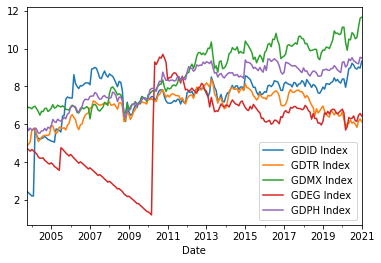

In [35]:
dur_monthly.iloc[:, :5].plot()

### Filter for countries with cluster results

In [36]:
oas_monthly.columns = oas_monthly.columns.map(ticker_dict)
# mv_monthly.columns = mv_monthly.columns.map(ticker_dict)
dur_monthly.columns = dur_monthly.columns.map(ticker_dict)

In [37]:
rating_monthly.rename(columns={'Korea':'South Korea'}, inplace=True)
rating_monthly_selected = rating_monthly[results_with_cluster['country']]

In [38]:
oas_monthly_selected = oas_monthly[results_with_cluster['country']]
# mv_monthly_selected = mv_monthly[results_with_cluster['country']]
dur_monthly_selected = dur_monthly[results_with_cluster['country']]

### Prepare measurement of value factor

In [39]:
oas_monthly_selected.columns = pd.MultiIndex.from_product([['oas'], oas_monthly_selected.columns])
dur_monthly_selected.columns = pd.MultiIndex.from_product([['dur'], dur_monthly_selected.columns])
rating_monthly_selected.columns = pd.MultiIndex.from_product([['rating'], rating_monthly_selected.columns])

<AxesSubplot:xlabel='Date'>

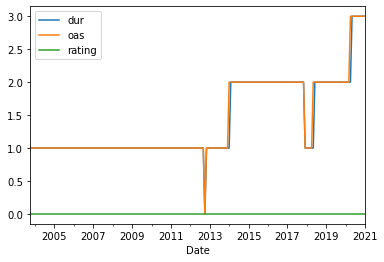

In [40]:
value_data = oas_monthly_selected.join(dur_monthly_selected).join(rating_monthly_selected)
value_data.columns = value_data.columns.sort_values()
value_data.replace(0, np.nan, inplace=True)

# check number of missing countries
value_data.T.groupby(level=0).apply(lambda x:x.isna().sum()).T.plot()

In [41]:
value_residuals = pd.DataFrame()

for index, row in value_data.iterrows():
    
    temp = row.unstack(level=0).dropna()
    if len(temp) > 24:
        # y = temp['oas']
        # X = temp[['dur', 'rating']]
        temp[['oas', 'dur']] = temp[['oas', 'dur']].astype('float')
        mod = smf.ols(formula="oas ~ dur + rating", data=temp)
        res = mod.fit()
        res_df = pd.DataFrame(data=res.resid, columns=[index]).T
        value_residuals = value_residuals.append(res_df)
    

### Prepare measurement of momentum factor

In [42]:
# change bond return dataframe column names from tickers to countries to align with factor dataframes
bnd_index_excess_ret.columns = bnd_index_excess_ret.columns.map(ticker_dict)

In [43]:
momentum = bnd_index_excess_ret.rolling(window=11).mean().shift(1)

In [44]:
momentum_selected = momentum.loc[oas_monthly_selected['oas'].index, oas_monthly_selected['oas'].columns]

### Construct factors and show their performances

In [45]:
dur_factor_ret, dur_factor_port = construct_factor(dur_monthly_selected['dur'], bnd_index_excess_ret, ascending=False)
carry_factor_ret, carry_factor_port = construct_factor(oas_monthly_selected['oas'], bnd_index_excess_ret, ascending=False)
value_factor_ret, value_factor_port = construct_factor(value_residuals, bnd_index_excess_ret, ascending=False)
mom_factor_ret, mom_factor_port = construct_factor(momentum_selected, bnd_index_excess_ret, ascending=False)

In [46]:
quality_factor_ret, quality_factor_port = construct_factor(rating_monthly_selected['rating'], bnd_index_excess_ret, ascending=False)

In [47]:
eqw_ret = bnd_index_excess_ret.mean(axis=1)
eqw_ret.name = 'equal_weighted'

In [48]:
style_factors_ret = pd.concat([dur_factor_ret, carry_factor_ret, value_factor_ret, mom_factor_ret, quality_factor_ret], axis=1)
style_factors = ['duration', 'carry', 'value', 'momentum', 'quality']
style_factors_ret.columns = style_factors

In [49]:
style_factors_ret = style_factors_ret.join(eqw_ret)

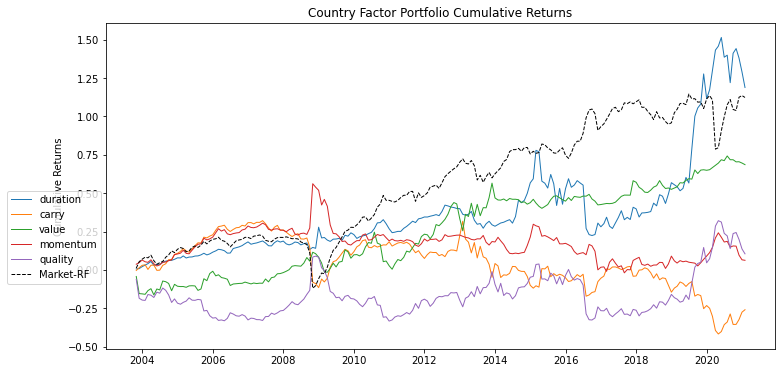

In [50]:
style_factors_cum_ret = calc_cum_returns(style_factors_ret)

# Plot cumulative returns
plot_perf(perf=[style_factors_cum_ret[x] for x in list(style_factors_cum_ret.columns.values)[:-1]],
          perf_bm=style_factors_cum_ret['equal_weighted_cum_ret'], 
          label=['duration', 'carry', 'value', 'momentum', 'quality'], 
          title='Country Factor Portfolio Cumulative Returns')

### Plot summary statistics of bond index returns and factor performance

In [51]:
style_factors_perf_container = []
for col in style_factors_ret.columns:
    perf_ = calc_performance(style_factors_ret[col])
    style_factors_perf_container.append(perf_)

style_factors_perf = pd.DataFrame(style_factors_perf_container, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = style_factors_ret.columns)
style_factors_perf

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
duration,21.63,24.77,0.87,-0.54,8.09,31.19,2016-09-30
carry,-7.24,27.99,-0.26,-1.38,6.46,55.90,2020-04-30
value,13.95,19.74,0.71,-0.55,3.31,19.40,2011-01-31
momentum,1.53,19.81,0.08,1.67,17.62,37.18,2017-08-31
quality,2.52,34.12,0.07,-0.15,4.77,38.83,2010-12-31
equal_weighted,20.72,19.11,1.08,-4.02,30.44,28.26,2008-10-31


In [52]:
macro_factors_perf_container = []
for col in macro_factors_ret.columns:
    perf_ = calc_performance(macro_factors_ret[col])
    macro_factors_perf_container.append(perf_)

macro_factors_perf = pd.DataFrame(macro_factors_perf_container, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = macro_factors_ret.columns)
macro_factors_perf

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
credit,35.39,19.83,1.78,-1.81,12.23,33.31,2008-11-30
currency,12.45,13.99,0.89,-0.75,1.96,18.95,2009-02-28
equity,40.65,29.23,1.39,-0.97,2.42,50.44,2009-02-28
rates,21.17,9.15,2.31,0.15,3.51,7.42,2014-01-31


In [53]:
bnd_index_ret.columns = bnd_index_ret.columns.map(ticker_dict)

In [54]:
bnd_index_ret_selected = bnd_index_ret.loc[bnd_index_ret.index > start_date, results_with_cluster['country']]

In [55]:
bnd_index_ret_selected.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
Bulgaria,124.0,0.005,0.021,-0.147,-0.002,0.006,0.013,0.059
Bolivia,164.0,-0.025,0.434,-1.386,-0.288,-0.080,0.223,1.861
Brazil,208.0,0.007,0.028,-0.100,-0.007,0.010,0.023,0.130
Chile,208.0,0.004,0.016,-0.045,-0.004,0.005,0.013,0.063
China,109.0,0.004,0.010,-0.032,-0.001,0.003,0.009,0.049
Colombia,208.0,0.006,0.027,-0.141,-0.006,0.008,0.020,0.105
Costa Rica,208.0,0.005,0.030,-0.197,-0.003,0.007,0.016,0.075
Dominican Republic,208.0,0.008,0.051,-0.499,-0.006,0.007,0.026,0.173
Egypt,208.0,0.005,0.032,-0.174,-0.003,0.006,0.016,0.098
Guatemala,208.0,0.006,0.024,-0.186,-0.001,0.009,0.017,0.061


In [56]:
display_single_factor_performance(bnd_index_ret_selected.dropna(axis=1), frequency='M')

NameError: name 'display_single_factor_performance' is not defined

In [ ]:
bnd_index_ret_labeled = bnd_index_ret_selected.T.merge(bond_idx_clusters, left_index=True, right_on='Countries')

In [ ]:
display_single_factor_performance(bnd_index_ret_labeled.groupby('cluster_label').mean().T, frequency='M')